In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

#Styling Block
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 26
FIG_SIZE = (12,6) #change figure size throughout for non-faceted figures
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style('white')
cp = sns.color_palette() #color palette to use throughout 

In [2]:
country = 'india'
scenario = 'base'
results_path = 'results_20201109_173617'

results = pd.read_csv(os.path.join(results_path,'india_base','agent_outputs.csv'))
results.rename({'metric_value':'payback_period'}, axis='columns', inplace=True)
results.head()

,agent_id,state_name,sector_abbr,geo_sector_n_agents,owner_occupancy_status,developable_buildings_pct,cap_cost_multiplier,district_name,developable_roof_sqft,load_per_customer_in_bin_kwh_initial,...,new_batt_kw,new_batt_kwh,number_of_adopters,market_value,pv_kw_cum,batt_kw_cum,batt_kwh_cum,total_gen_twh,index,max_market_share_last_year
0,0,daman_diu,res,2,1,1,1,daman,237.384538,6.557251e+02,...,0.0,0.0,1.159168,0.000000,0.000000,0.0,0.0,0.000000,0,NaN
1,1,daman_diu,res,2,1,1,1,daman,48.027824,1.317866e+03,...,0.0,0.0,0.732201,0.000000,0.000000,0.0,0.0,0.000000,1,NaN
2,2,daman_diu,ind,27,1,1,1,daman,6346.065700,1.250592e+06,...,0.0,0.0,0.011655,1801.716894,1.099965,0.0,0.0,0.000002,2,NaN
3,3,daman_diu,ind,27,1,1,1,daman,11216.986747,2.078164e+06,...,0.0,0.0,0.009536,2605.601634,1.590744,0.0,0.0,0.000003,3,NaN
4,4,daman_diu,ind,27,1,1,1,daman,12555.489022,1.283660e+07,...,0.0,0.0,0.009536,2916.523256,1.780564,0.0,0.0,0.000003,4,NaN


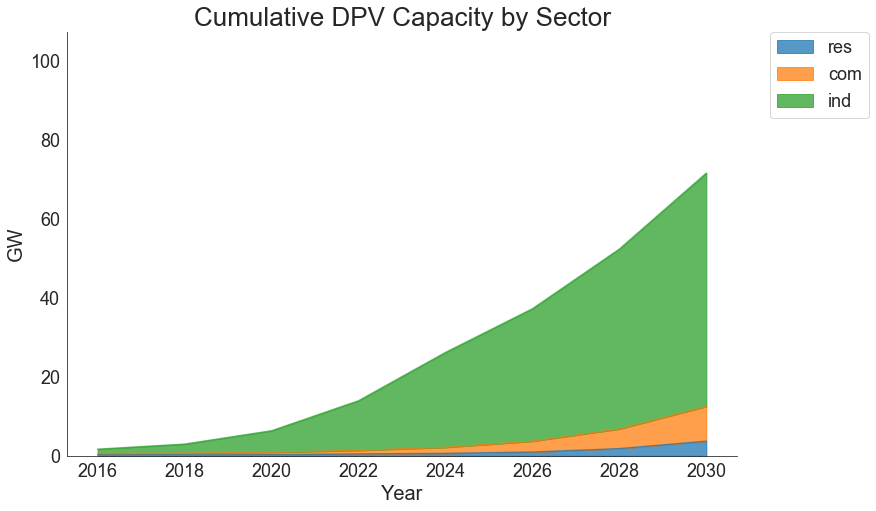

In [3]:
data = results.copy()
data['pv_GW_cum'] = data['pv_kw_cum'] / 1e6
deployment = data.groupby(['year','sector_abbr'])['pv_GW_cum'].sum().reset_index()
deployment = deployment.pivot(index='year', columns='sector_abbr', values='pv_GW_cum')

df = deployment[['res','com','ind']]

fig, ax = plt.subplots(figsize=(FIG_SIZE[0], FIG_SIZE[1]*1.3))
df.plot.area(ax=ax, alpha=0.75)

# --- Readjust ylim ---
ax.set_ylim((0, max(list(deployment.sum(axis=1))) * 1.5))

ax.set_title(f'Cumulative DPV Capacity by Sector')
ax.set_ylabel('GW')
ax.set_xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(fig)

Text(0.5, 0, 'Payback Period')

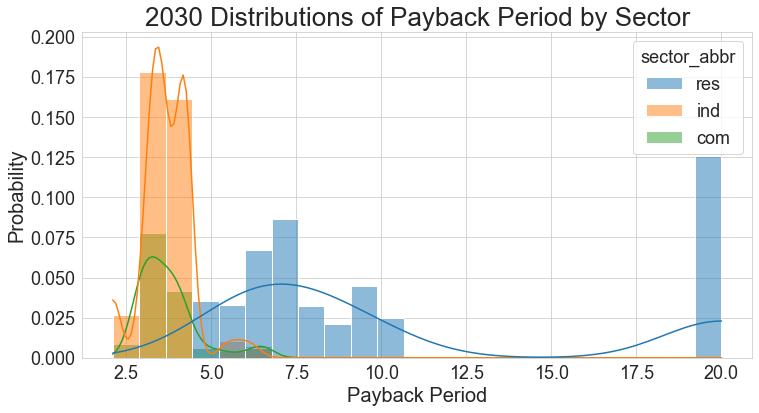

In [4]:
# --- HISTOGRAM OF PAYBACK IN 2030---
sns.set_style('whitegrid')

data_2030 = results.loc[results['year'] == 2030]

fig, ax = plt.subplots(figsize=FIG_SIZE)
sns.histplot(data_2030, x="payback_period", hue='sector_abbr', stat='probability', kde=True, ax=ax)

ax.set_title('2030 Distributions of Payback Period by Sector')
ax.set_xlabel('Payback Period')

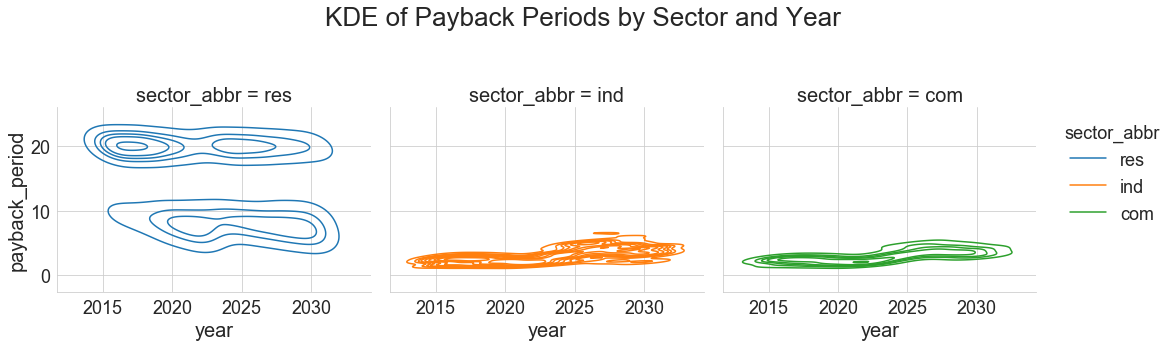

In [5]:
# --- KDE PLOT OF PAYBACK PERIODS BY YEAR ---
g = sns.displot(
    data=results,
    x='year', y='payback_period',
    col='sector_abbr', hue='sector_abbr',
    kind='kde'
)

g.fig.suptitle('KDE of Payback Periods by Sector and Year')
g.fig.subplots_adjust(top=.7)

In [6]:
results.loc[results['state_name']=='karnataka']\
    .groupby(['year'])['pv_kw_cum'].sum() / 1000

year
2016     132.485809
2018     208.620984
2020     404.167200
2022     848.422637
2024    1673.655393
2026    2627.296291
2028    3724.843098
2030    4957.103475
Name: pv_kw_cum, dtype: float64

In [7]:
# --- PIVOT of ADOPTION BY DISTRICT AND SECTOR ---
pivot = results.pivot_table(
    index=['state_name','district_name','sector_abbr'],
    columns='year',
    values='pv_kw_cum',
    aggfunc='sum',
    margins=True
)

pivot = pivot / 1000 #kW to MW
pivot.reset_index(inplace=True)

pivot.to_csv(f"{results_path}_dpv_MW.csv")
pivot.tail(1)

year,state_name,district_name,sector_abbr,2016,2018,2020,2022,2024,2026,2028,2030,All
521,All,,,1666.579031,2948.013898,6329.151124,13924.021657,26160.511621,37230.616117,52353.595276,71606.356818,212218.845543


In [8]:
# --- NET LOAD 8760s by YEAR / STATE ---
os.getcwd()

'/Users/skoebric/Documents/NREL-GitHub/dgen_globetrotter/runs'

In [22]:
scenario_folder = os.path.join('..','input_scenarios',f"{country}_{scenario}")

# --- load by sector ---
load_profile = pd.read_json(os.path.join(scenario_folder, 'normalized_load.json'))

# --- cumulative load by year / sector ---
district_cum_load = results.groupby(['state_id','state_name','district_id','district_name','sector_abbr','year'], as_index=False)[['load_in_bin_kwh', 'pv_kw_cum','tilt']].sum()

# --- denormalize load ---
merged = district_cum_load.merge(load_profile, on='sector_abbr')
denormalize = lambda x: np.array(x['kwh']) * (sum(x['kwh']) / x['load_in_bin_kwh'])
merged['denormed'] = merged.apply(denormalize, axis=1)
merged

# --- load solar by district ---
descale = lambda x: x / 1e3
solar_cf = pd.read_json(os.path.join(scenario_folder, 'solar_resource_hourly.json'))
solar_cf['cf'] = solar_cf['cf'].apply(descale)
merged.merge(solar_cf, on=['district_id', 'tilt'])

scale_solar = lambda x: np.array(x['cf']) * (sum(x['cf']) / x['load_in_bin_kwh'])
merged


,state_id,state_name,district_id,district_name,sector_abbr,year,load_in_bin_kwh,pv_kw_cum,tilt,kwh,denormed
0,1,jammu_kashmir,1,kupwara,res,2016,1.662153e+07,51.114134,105,"[26.6424503326, 25.2289905548, 24.2130794525, ...","[0.48086650456163516, 0.45535513251424203, 0.4..."
1,1,jammu_kashmir,1,kupwara,res,2018,1.827993e+07,51.114134,105,"[26.6424503326, 25.2289905548, 24.2130794525, ...","[0.4372411142643235, 0.41404419654475266, 0.39..."
2,1,jammu_kashmir,1,kupwara,res,2020,2.026975e+07,51.114134,105,"[26.6424503326, 25.2289905548, 24.2130794525, ...","[0.3943184078001799, 0.3733986649794639, 0.358..."
3,1,jammu_kashmir,1,kupwara,res,2022,2.251002e+07,97.571710,105,"[26.6424503326, 25.2289905548, 24.2130794525, ...","[0.35507453764197605, 0.3362367967130287, 0.32..."
4,1,jammu_kashmir,1,kupwara,res,2024,2.535567e+07,97.571710,105,"[26.6424503326, 25.2289905548, 24.2130794525, ...","[0.3152247370032668, 0.29850114434720726, 0.28..."
...,...,...,...,...,...,...,...,...,...,...,...
4163,35,andaman_nicobar_islands,640,south_andaman,com,2022,1.531006e+08,167.041012,120,"[26.0916805267, 28.3457794189, 28.5820503235, ...","[0.0511265335338376, 0.05554343042488754, 0.05..."
4164,35,andaman_nicobar_islands,640,south_andaman,com,2024,1.717734e+08,333.231649,120,"[26.0916805267, 28.3457794189, 28.5820503235, ...","[0.045568780468132605, 0.049505534847254, 0.04..."
4165,35,andaman_nicobar_islands,640,south_andaman,com,2026,1.932430e+08,647.734526,120,"[26.0916805267, 28.3457794189, 28.5820503235, ...","[0.04050602294299852, 0.044005398207455235, 0...."
4166,35,andaman_nicobar_islands,640,south_andaman,com,2028,2.134239e+08,1240.203495,120,"[26.0916805267, 28.3457794189, 28.5820503235, ...","[0.036675856844323756, 0.03984433839148503, 0...."


In [10]:
merged

,state_id,state_name,district_id,district_name,sector_abbr,year,load_in_bin_kwh,pv_kw_cum,tilt,kwh,denormed
0,1,jammu_kashmir,1,kupwara,res,2016,1.662153e+07,51.114134,105,"[26.6424503326, 25.2289905548, 24.2130794525, ...","[0.48086650456163516, 0.45535513251424203, 0.4..."
1,1,jammu_kashmir,1,kupwara,res,2018,1.827993e+07,51.114134,105,"[26.6424503326, 25.2289905548, 24.2130794525, ...","[0.4372411142643235, 0.41404419654475266, 0.39..."
2,1,jammu_kashmir,1,kupwara,res,2020,2.026975e+07,51.114134,105,"[26.6424503326, 25.2289905548, 24.2130794525, ...","[0.3943184078001799, 0.3733986649794639, 0.358..."
3,1,jammu_kashmir,1,kupwara,res,2022,2.251002e+07,97.571710,105,"[26.6424503326, 25.2289905548, 24.2130794525, ...","[0.35507453764197605, 0.3362367967130287, 0.32..."
4,1,jammu_kashmir,1,kupwara,res,2024,2.535567e+07,97.571710,105,"[26.6424503326, 25.2289905548, 24.2130794525, ...","[0.3152247370032668, 0.29850114434720726, 0.28..."
...,...,...,...,...,...,...,...,...,...,...,...
4163,35,andaman_nicobar_islands,640,south_andaman,com,2022,1.531006e+08,167.041012,120,"[26.0916805267, 28.3457794189, 28.5820503235, ...","[0.0511265335338376, 0.05554343042488754, 0.05..."
4164,35,andaman_nicobar_islands,640,south_andaman,com,2024,1.717734e+08,333.231649,120,"[26.0916805267, 28.3457794189, 28.5820503235, ...","[0.045568780468132605, 0.049505534847254, 0.04..."
4165,35,andaman_nicobar_islands,640,south_andaman,com,2026,1.932430e+08,647.734526,120,"[26.0916805267, 28.3457794189, 28.5820503235, ...","[0.04050602294299852, 0.044005398207455235, 0...."
4166,35,andaman_nicobar_islands,640,south_andaman,com,2028,2.134239e+08,1240.203495,120,"[26.0916805267, 28.3457794189, 28.5820503235, ...","[0.036675856844323756, 0.03984433839148503, 0...."


In [21]:
import json
import ast

solar_cf = pd.read_json(os.path.join(scenario_folder, 'solar_resource_hourly.json'))
solar_cf


,district_id,resource_id,tilt,azimuth,cf
0,640,666,15,180,"[0, 36, 255, 391, 554, 633, 664, 632, 496, 349..."
1,532,341,15,180,"[0, 0, 0, 231, 397, 515, 575, 541, 566, 497, 3..."
2,542,512,15,180,"[0, 0, 119, 289, 447, 556, 615, 623, 580, 487,..."
3,552,285,15,180,"[0, 0, 0, 254, 433, 566, 639, 403, 348, 269, 3..."
4,256,678,25,180,"[0, 0, 213, 413, 490, 304, 194, 173, 126, 69, ..."
...,...,...,...,...,...
80,62,417,35,180,"[0, 0, 0, 366, 628, 755, 769, 769, 769, 769, 6..."
81,68,288,25,180,"[0, 0, 0, 181, 382, 529, 618, 650, 598, 415, 3..."
82,56,329,35,180,"[0, 0, 0, 306, 564, 610, 686, 769, 725, 560, 3..."
83,333,607,25,180,"[0, 0, 148, 328, 481, 580, 620, 613, 546, 436,..."
